In [2]:
from google.colab import drive

# Google 드라이브 마운트
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# 모델 입력 크기 (Inception v4의 경우 299x299)
image_size = (299, 299)

# 상위 디렉토리 경로 설정
train_directory = "/content/drive/MyDrive/train"

# 하위 디렉토리 리스트
subdirectories = ["BoiledDown", "Rice", "Noodle", "Roasted", "Kimchi"]

# 이미지와 레이블 데이터를 저장할 리스트 초기화
images = []
labels = []

# 각 하위 디렉토리에서 이미지 파일을 불러오기 및 전처리
for label, subdir in enumerate(subdirectories):
    subdir_path = os.path.join(train_directory, subdir)
    image_files = [os.path.join(subdir_path, f) for f in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, f))]

    # 이미지 파일을 무작위로 섞기
    np.random.shuffle(image_files)

    # 각 클래스별로 200장의 이미지만 선택
    selected_files = image_files[:200]

    for image_file in selected_files:
        image = cv2.imread(image_file)
        if image is None:
            print(f"Error loading image: {image_file}")
            continue
        image_resized = cv2.resize(image, image_size)
        image_resized = image_resized.astype(np.float32) / 255.0  # 정규화
        images.append(image_resized)
        labels.append(label)

# 리스트를 numpy 배열로 변환
images_np = np.array(images)
labels_np = np.array(labels)

# TensorFlow 데이터셋으로 변환
dataset = tf.data.Dataset.from_tensor_slices((images_np, labels_np))

# 데이터 증강 함수 정의
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label

# 데이터셋을 섞고, 증강 및 배치 단위로 나누기
batch_size = 32
dataset = dataset.shuffle(buffer_size=len(images_np)).map(augment).batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

# 사전 학습된 InceptionV3 모델 로드
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# 새로운 레이어 추가
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(subdirectories), activation='softmax')(x)

# 새로운 모델 정의
model = Model(inputs=base_model.input, outputs=predictions)

# 사전 학습된 레이어는 학습되지 않도록 설정
for layer in base_model.layers:
    layer.trainable = False



Error loading image: /content/drive/MyDrive/train/BoiledDown/Img_108_0176.jpg
Error loading image: /content/drive/MyDrive/train/Noodle/Img_050_0468.jpg
Error loading image: /content/drive/MyDrive/train/Kimchi/Img_031_0021.jpg
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [4]:
# 레이블을 원-핫 인코딩으로 변환
labels_np = tf.keras.utils.to_categorical(labels_np, num_classes=len(subdirectories))

# TensorFlow 데이터셋으로 변환
# 배치 크기를 적용하기 전에 원-핫 인코딩을 수행합니다.
dataset = tf.data.Dataset.from_tensor_slices((images_np, labels_np))
dataset = dataset.shuffle(buffer_size=len(images_np)).batch(batch_size) # Move batching after one-hot encoding

# 모델 컴파일
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [5]:


# Early Stopping과 Model Checkpoint 콜백 설정
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True) # Change the file extension to '.keras'

# 모델 학습
model.fit(dataset,
          epochs=10,
          validation_data=dataset,
          callbacks=[early_stopping, checkpoint])


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 53s 914ms/step - accuracy: 0.3023 - loss: 2.5032 - val_accuracy: 0.5667 - val_loss: 1.0439
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 316ms/step - accuracy: 0.6211 - loss: 0.9791 - val_accuracy: 0.6871 - val_loss: 0.8288
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 308ms/step - accuracy: 0.7179 - loss: 0.7578 - val_accuracy: 0.6861 - val_loss: 0.7365
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 292ms/step - accuracy: 0.7836 - loss: 0.6464 - val_accuracy: 0.8325 - val_loss: 0.5094
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 321ms/step - accuracy: 0.7809 - loss: 0.5790 - val_accuracy: 0.8275 - val_loss: 0.4873
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 298ms/step - accuracy: 0.8319 - loss: 0.4632 - val_accuracy: 0.8606 - val_loss: 0.3988
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 301ms/step - accuracy: 0.8532 - loss: 0.4296 - val_accuracy: 0.9218 - val_loss: 0.2970
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 288ms/step - accuracy: 0.9204 - loss: 0.3103 - val_accu

In [ ]:
#AUC 0.74에 대해서는 생략한 결과


# 몇 에포크 후, 모델의 일부 층을 미세 조정 위해 동결 해제
for layer in base_model.layers[-50:]:  # 마지막 50개의 층을 해제
    layer.trainable = True

# 학습률을 낮추고 모델을 재컴파일
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 모델을 추가 학습
model.fit(dataset,
          epochs=10,
          validation_data=dataset,
          callbacks=[early_stopping, checkpoint])

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 53s 942ms/step - accuracy: 0.8106 - loss: 0.5080 - val_accuracy: 0.8959 - val_loss: 0.2556
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 521ms/step - accuracy: 0.9715 - loss: 0.1137 - val_accuracy: 0.9870 - val_loss: 0.0440
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 754ms/step - accuracy: 0.9984 - loss: 0.0270 - val_accuracy: 0.9940 - val_loss: 0.0324
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 553ms/step - accuracy: 0.9999 - loss: 0.0123 - val_accuracy: 1.0000 - val_loss: 0.0054
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 862ms/step - accuracy: 0.9983 - loss: 0.0156 - val_accuracy: 1.0000 - val_loss: 0.0033
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 962ms/step - accuracy: 0.9998 - loss: 0.0072 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 299ms/step - accuracy: 0.9989 - loss: 0.0069 - val_accuracy: 1.0000 - val_loss: 0.0019
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 308ms/step - accuracy: 0.9948 - loss: 0.0180 - val_accu

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step


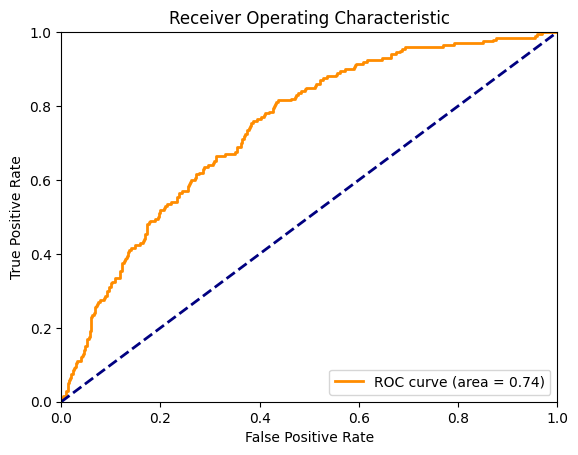

AUC Score: 0.74


In [7]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ROC 곡선 및 AUC 점수 계산
y_pred = model.predict(images_np)
y_pred_prob = np.max(y_pred, axis=1)

# Convert one-hot encoded labels back to single integer labels
labels_np_single = np.argmax(labels_np, axis=1)

fpr, tpr, _ = roc_curve(labels_np_single, y_pred_prob, pos_label=1) # Use single integer labels
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f"AUC Score: {roc_auc:.2f}")

In [9]:
from sklearn.metrics import accuracy_score

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded true labels to class indices
y_true_classes = np.argmax(labels_np, axis=1)

# Now calculate accuracy using class indices for both true and predicted labels
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.93
